#Planet Hunters Notebook 1


Since ancient history, humans have looked up into space and wondered: are we alone? There are an estimated 1 billion trillion (1,000,000,000,000,000,000,000) stars in the universe, and it wasn't until 1992 (!) that scientists discovered an exoplanet (a planet orbiting a star other than our own). Thanks to new technology, we now know that not only do exoplanets exist, but they are actually common in the universe! In this notebook, you will learn about transit photometry, the state-of-the-art method used by astronomers and astrophysicists for detecting exoplanets. You will gain experience with visualizing light curves and vetting them for exoplanets.

In the later notebooks of this project, you'll use machine learning to automate the search for exoplanets, using a variety of models and data augmentation techniques!

In this notebook, we'll be:
1. Understanding Transit Photometry and exoplanet detection
2. Understanding and visualizing our planet data
3. Learning how to identify exoplanets

##Milestone 1: Understanding Transit Photometry


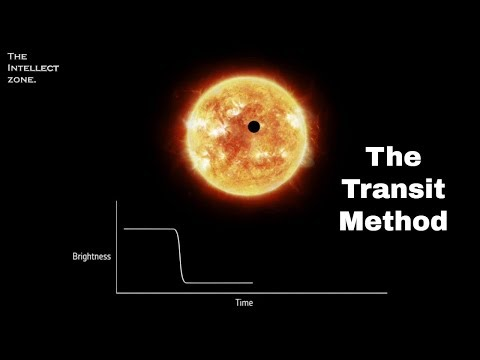

In [ ]:
#@title Watch the video below to learn about exoplanet detection!
from IPython.display import YouTubeVideo
YouTubeVideo('mvK1TslAAaw')

**Transit Photometry Summary**

The idea behind the transit method for exoplanet detection is that planets orbiting other stars are too dark and far away to be imaged directly. Instead, we have to rely on indirect means for detecting their presence. We do this by monitoring the brightness (or flux) of stars over time. If we see dips in the star's brightness at regular intervals, we can infer that these dips may be caused by an orbiting planet. The plot we generate when we measure a star's brightness over time is called a light curve. Here is an example of a light curve below.

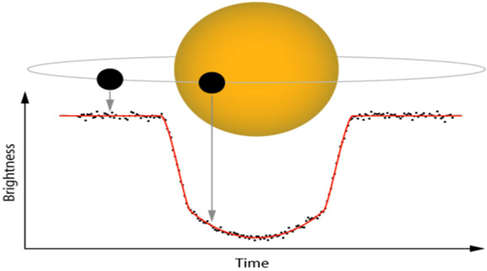

###Exercise: Discussion of Transit Dips

Without ever knowing it, you've probably understood all of the physics behind transit photometry since you were a little kid!


**Question:**
> What happens when you put your hand in front of a flashlight?




If you've ever found yourself making flashlight shadow puppets, you have demonstrated the foundations of the transit photometry method. By taking a light source (a flashlight /star) and putting a non-luminous object in front of it (your hand / a planet), the non-luminous object blocks the light of the source forming a shadow (a puppet on the wall / a transit dip).

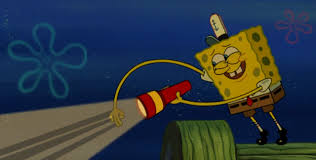

**Discuss:** If you visualized a star's light data and saw this, would it likely represent an exoplanet or not an exoplanet? Why?

 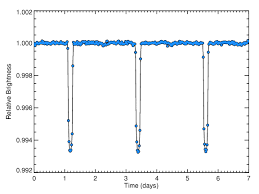

##Milestone 2: Understanding and Visualizing the Data

In [ ]:
#@title Run this to Import Data and Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# original source: https://www.kaggle.com/keplersmachines/kepler-labelled-time-series-data
!wget -q --show-progress 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Planet%20Hunters/exoTrain.csv'
!wget -q --show-progress 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Planet%20Hunters/exoTest.csv'

raw_data = np.loadtxt('exoTrain.csv', skiprows=1, delimiter=',')
x_train = raw_data[:, 1:]
y_train = raw_data[:, 0, np.newaxis] - 1.
raw_data = np.loadtxt('exoTest.csv', skiprows=1, delimiter=',')
x_test = raw_data[:, 1:]
y_test = raw_data[:, 0, np.newaxis] - 1.
del raw_data

flux_data = pd.read_csv('exoTrain.csv', index_col=0)

def reduce_upper_outliers(df, reduce=0.01, half_width=4):
    length = len(df.iloc[0,:])
    remove = int(length*reduce)
    for i in df.index.values:
        values = df.loc[i,:]
        sorted_values = values.sort_values(ascending = False)
        for j in range(remove):
            idx = sorted_values.index[j]
            new_val = 0
            count = 0
            idx_num = int(idx[5:])
            for k in range(2*half_width+1):
                idx2 = idx_num + k - half_width
                if idx2 < 1 or idx2 >= length or idx_num == idx2:
                    continue
                new_val += values['FLUX-'+str(idx2)]

                count += 1
            new_val /= count # count will always be positive here
            if new_val < values[idx]: # just in case there's a few persistently high adjacent values
                df.set_value(i, idx, new_val)


    return df

def plot_light_curve(dataset, index):
  plt.figure()
  plt.plot(np.array(dataset[index:index+1])[0])
  plt.show()

exoTrain.csv        100%[===================>] 250.08M  76.5MB/s    in 3.4s    
exoTest.csv         100%[===================>]  27.57M   106MB/s    in 0.3s    


We've downloaded a NASA dataset from the Kepler Space Telescope! Each row represents measurements of the flux (light intensity) of a particular star. Read more about the dataset [here](https://www.kaggle.com/keplersmachines/kepler-labelled-time-series-data).

###Exercise: Understanding the Dataset with Pandas

What does each column represent in our training data? **Print out the first five rows of the data frame.**

*Revisit an old notebook if you need help remembering the method for showing the first five rows!*

In [ ]:
flux_data = pd.read_csv('exoTrain.csv', index_col=False) # Read in the exoplanet training data using Pandas
flux_data['LABEL'] = flux_data['LABEL'] - 1 # Change the labels to be 1 for exoplanet and 0 for non-exoplanet

# Print the first five rows of the data frame
### YOUR CODE HERE
flux_data.head()
### END CODE HERE

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,1,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,1,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,1,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,1,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,1,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


###Exercise: Discussion of Data Frame


1. How many columns are in the data frame?
2. What do you think these columns represent?
3. Do you think there is any ordering to the flux data columns?
4. What might the negative flux values represent?

Now, let's separate the label column from the rest of the data frame.

In [ ]:
labels = flux_data['LABEL']
flux_data = flux_data.drop('LABEL', axis=1) # Drop the labels from the data frame, leaving only the flux data

display(flux_data)
display(labels)

,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,FLUX.10,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,-160.17,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,-73.38,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,484.39,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,323.33,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,-970.88,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5082,-91.91,-92.97,-78.76,-97.33,-68.00,-68.24,-75.48,-49.25,-30.92,-11.88,...,139.95,147.26,156.95,155.64,156.36,151.75,-24.45,-17.00,3.23,19.28
5083,989.75,891.01,908.53,851.83,755.11,615.78,595.77,458.87,492.84,384.34,...,-26.50,-4.84,-76.30,-37.84,-153.83,-136.16,38.03,100.28,-45.64,35.58
5084,273.39,278.00,261.73,236.99,280.73,264.90,252.92,254.88,237.60,238.51,...,-26.82,-53.89,-48.71,30.99,15.96,-3.47,65.73,88.42,79.07,79.43
5085,3.82,2.09,-3.29,-2.88,1.66,-0.75,3.85,-0.03,3.28,6.29,...,10.86,-3.23,-5.10,-4.61,-9.82,-1.50,-4.65,-14.55,-6.41,-2.55


0       1
1       1
2       1
3       1
4       1
       ..
5082    0
5083    0
5084    0
5085    0
5086    0
Name: LABEL, Length: 5087, dtype: int64

###Exercise: Separate Exoplanets from Non-Exoplanets

In this dataset, a label of 1 indicates a star that has an exoplanet, and a label of 0 indicates some false positive source that is not an exoplanet.

**Let's use the [`dataframe.loc`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.loc.html) property to separate the exoplanets from the non-exoplanets.** In the `non_exo_data` example below, we use `labels==0`, which will produce an array of `True` and `False` values based on whether each label is 0. `.loc` can then use this to select only the rows of the dataframe that have `True` at the same position in that array!

**Exercise**: Can you fill in the rest of the code to select the `exo_data`?

In [ ]:
non_exo_data = flux_data.loc[labels==0] # Select only rows with label 0
exo_data =  flux_data.loc[labels !=0]### YOUR CODE HERE
exo_data

,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,FLUX.10,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,-160.17,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,-73.38,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,484.39,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,323.33,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,-970.88,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54
5,211.10,163.57,179.16,187.82,188.46,168.13,203.46,178.65,166.49,139.34,...,-98.45,30.34,30.34,29.62,28.80,19.27,-43.90,-41.63,-52.90,-16.16
6,9.34,49.96,33.30,9.63,37.64,20.85,4.54,22.42,10.11,40.10,...,-58.56,9.93,9.93,23.50,5.28,-0.44,10.90,-11.77,-9.25,-36.69
7,238.77,262.16,277.80,190.16,180.98,123.27,103.95,50.70,59.91,110.19,...,-72.48,31.77,31.77,53.48,27.88,95.30,48.86,-10.62,-112.02,-229.92
8,-103.54,-118.97,-108.93,-72.25,-61.46,-50.16,-20.61,-12.44,1.48,11.55,...,43.92,7.24,7.24,-7.45,-18.82,4.53,21.95,26.94,34.08,44.65
9,-265.91,-318.59,-335.66,-450.47,-453.09,-561.47,-606.03,-712.72,-685.97,-753.97,...,3671.03,2249.28,2249.28,2437.78,2584.22,3162.53,3398.28,3648.34,3671.97,3781.91


In our training data, do we have more **exoplanets** or **non-exoplanets**? (Hint: `len()`)

In [ ]:
### YOUR CODE HERE
print(len(exo_data))
print(len(non_exo_data))

37
5050


**Discuss:** How could this pose a challenge?

###Exercise: Visualizing Light Curves

To get a sense for what these real light curves look like, use the following function in a loop to **plot 5 light curves from the exoplanet category**.

`plot_light_curve(dataset, index)`

**Discuss:** What does the value for `index` tell us?


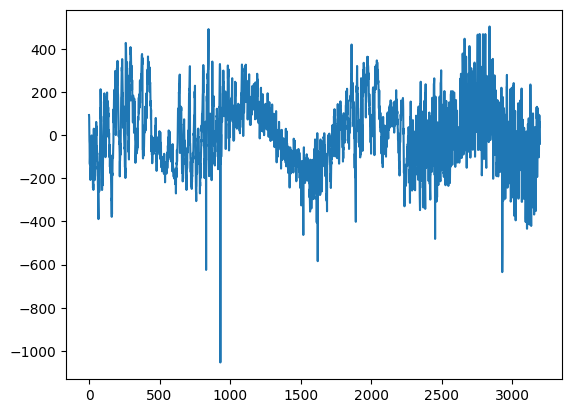

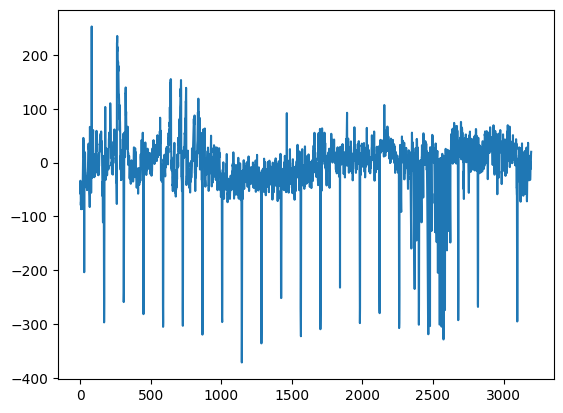

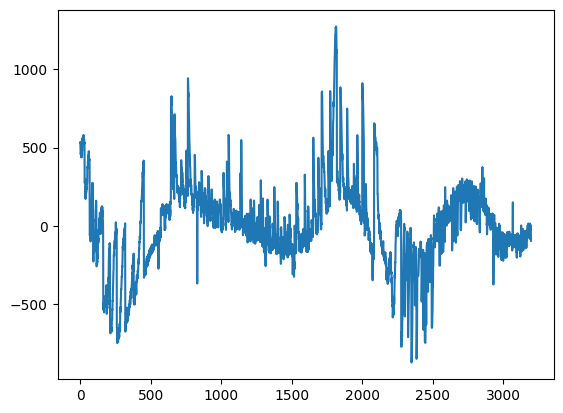

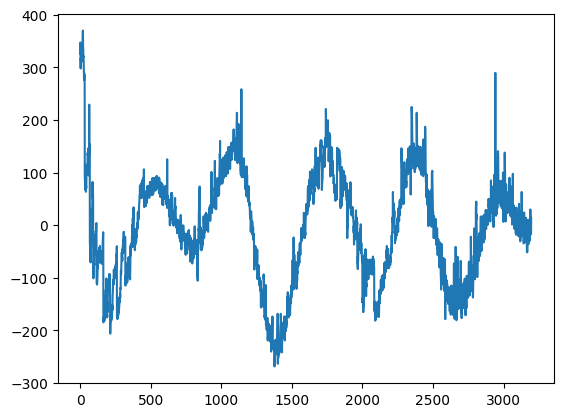

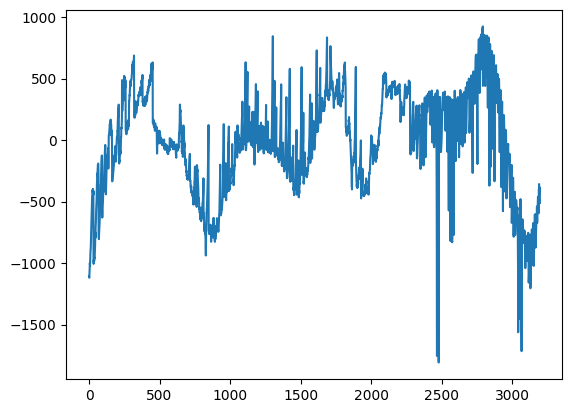

In [ ]:
### YOUR CODE HERE
for i in range(5):
  plot_light_curve(exo_data, i)
### END CODE HERE

**Discuss:** What do you notice? Do the light curves look as you'd expect, or is the real data messier than the artificial example above?

Now, let's **do the same thing for the non-exoplanet category!**

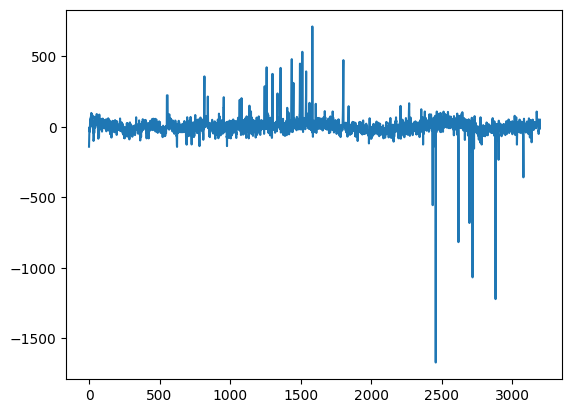

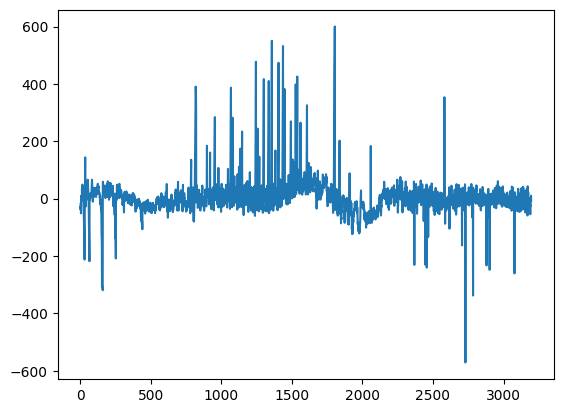

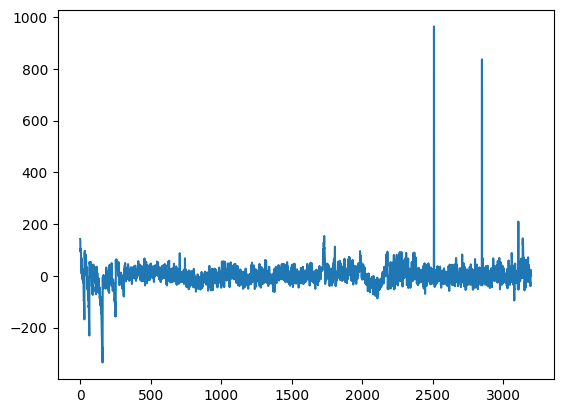

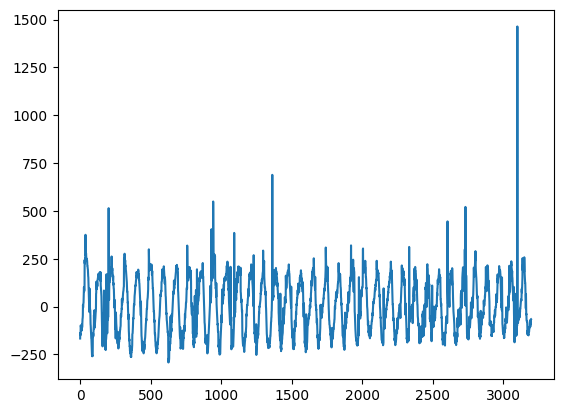

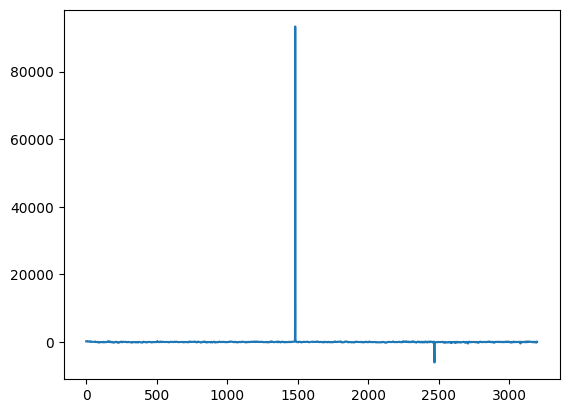

In [ ]:
### YOUR CODE HERE
for i in range(5):
  plot_light_curve(non_exo_data, i)
### END CODE HERE

**Discuss:** What do you notice about the non-exoplanets? Could you tell the difference between an exoplanet and a non-exoplanet from its graph?

##Milestone 3: Manual Detection of Exoplanets

###Exercise: Can You Guess if This Light Curve is an Exoplanet?



1


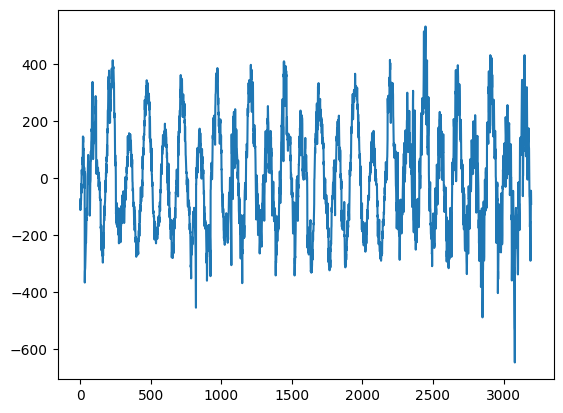

In [ ]:
#@title Run this to print a random light curve
import random
val=random.randint(0, 1)
print(val)
if (val==1):
  plot_light_curve(non_exo_data, random.randint(0, len(non_exo_data)))
  title='The true answer is non-exoplanet!'
else:
  plot_light_curve(exo_data, random.randint(0, len(exo_data)))
  title='The true answer is exoplanet!'


Make a guess below about what kind of light curve this is!

In [ ]:
light_curve_type_guess = "Exoplanet" #@param ["Exoplanet", "Non-exoplanet"]
print(title)

The true answer is exoplanet!


###Exercise: Discussion about what to look for in exoplanet classification


**Question:**
> What did you look for when you were determining if a light curve represented an exoplanet?

When scientists search for new planets, one of the most important things they want to measure is the  planet's period (i.e. how long does it take the planet to orbit around its star?).

**Question:**
> What is the period of Earth?


Now, we're going to get some practice with determining the period of exoplanets. To do so, we're going to start by plotting exoplanet light curve #12, because this is an easy example to begin with.

###Exercise: Plot Exoplanet Light Curve #12

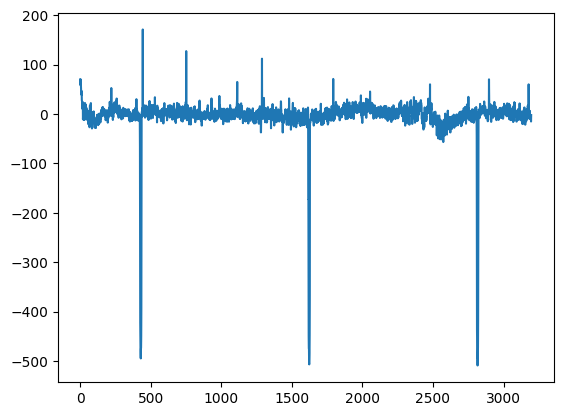

In [ ]:
### YOUR CODE HERE
i = 12
plot_light_curve(exo_data, i)
### END CODE HERE

###Exercise: Discussion about Determining Light Curve Period

1.   From this plot, does it look like there is an exoplanet circling this star with a regular period?
2.   Approximately what do you think the period of this exoplanet is? (Each time step is about 30 minutes.)
3.   Looking at the plot, do you think the telescope started measuring the brightness of the star at the start, middle, or end of one period?


###Exercise: Plotting One Period of the Exoplanet Orbit

To recognize exoplanets, we need to get comfortable finding the period from a graph!

Here, we want to try to visualize one period of the exoplanet transit (starting at a dip and ending at a dip). Let's see if we can find the time `t_0`, the time at which the first transit (dip in plot) starts. Then, we will see if we can find the period length (time from dip to dip), so we can plot one period from start to finish.

*Hint:* to begin, set the period to 3197 to first figure out `t_0`. Then, reset the period.

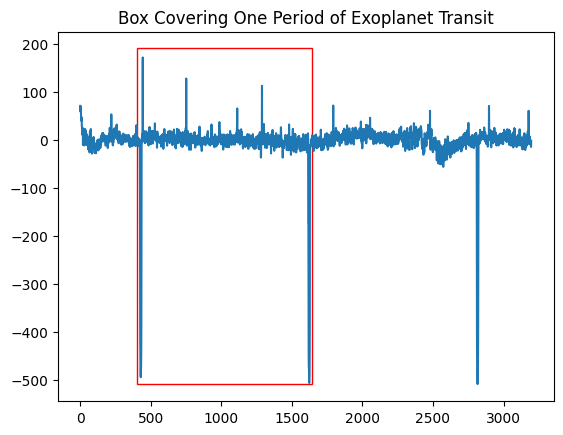

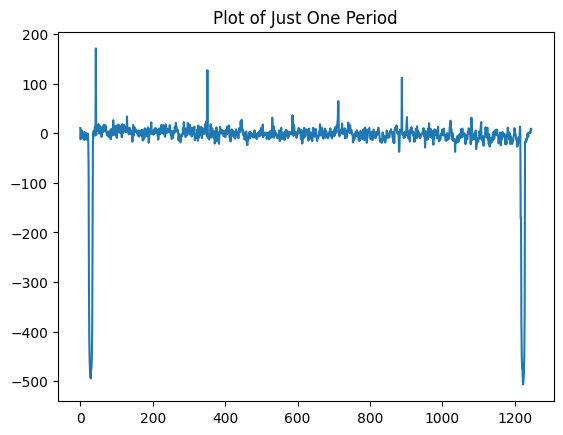

In [ ]:
index = 12 #@param {type:"slider", min:0, max:37, step:1}
t_0 = 400 #@param {type:"slider", min:0, max:3197, step:1}
period = 1246 # @param {type:"slider", min:0, max:3197, step:1}

from matplotlib.patches import Rectangle
light_curve=np.array(exo_data.loc[index])
plt.plot(light_curve)
plt.title('Box Covering One Period of Exoplanet Transit')
plt.gca().add_patch(Rectangle((t_0, -510), period, 700, linewidth=1,edgecolor='r',facecolor='none'))
plt.show()

plt.plot(light_curve[t_0: t_0+period])
plt.title('Plot of Just One Period')
plt.show()

###Exercise: Folding Light Curves

Now, let's try to manually determine if something is an exoplanet! You want to check: is the period the same for all of the dips?

The method used to check this is known as **folding**. Folding means plotting all of the periods on top of each other to see if there is a consistent trend.

*Note:* there is a lot of noise in this data, so each period will not be quite identical. Most importantly, we want to check if the dips occur at roughly the same places.


Below, set the time at which period 1 starts as `start_period_1` and the time at which period 2 starts as `start_period_2`, using your variables `t_0` and `period` from before. Then plot two versions of the curve: starting from the first period and starting from the second period!


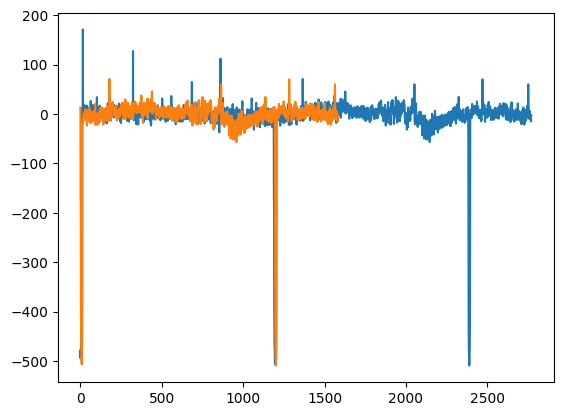

In [ ]:
#Plot the curve starting from Period 1
start_period_1 = 427 ### YOUR CODE HERE - time of first transit
plt.plot(light_curve[start_period_1:]) #plots the first curve

#Plot the curve starting from Period 2
### YOUR CODE HERE
start_period_2 = 427+1187
plt.plot(light_curve[start_period_2:])

###Exercise: Discussion of Light Curve Folding

1. How does "folding" help us identify if there's a regular period? What happens if you chose the wrong period previously?
2.   In the light curve above, do the transit dips come at roughly consistent periods? Planets are locked by gravity in regular orbits around their star, so if yes, you may have identified a planet!
3.  If these are different periods of the same planetary orbit, we would expect them to be almost identical. How can we account for the slight differences in the flux?



###Exercise: Try this for a Non-Exoplanet

So what happens if we use folding to find a period when there isn't one?

Below, plot non-exoplanet light curve #25.

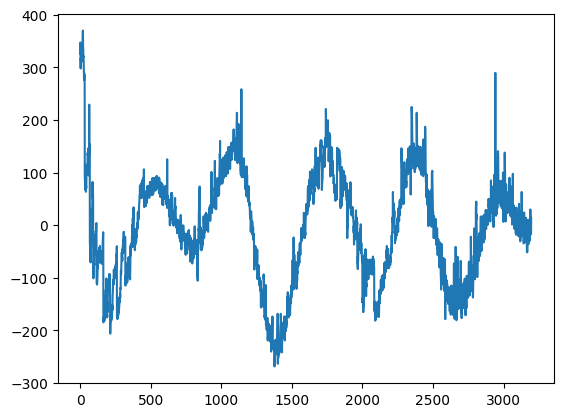

In [ ]:
### YOUR CODE HERE
plot_light_curve(exo_data, 3)
### END CODE HERE

It looks like there might be some sort of period here! Try to find one using the process from before (set `index` to 25):

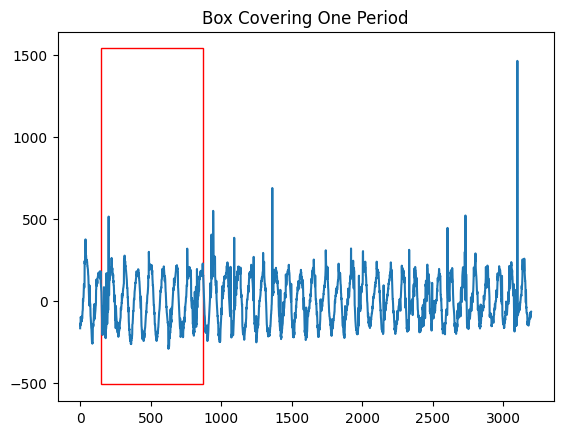

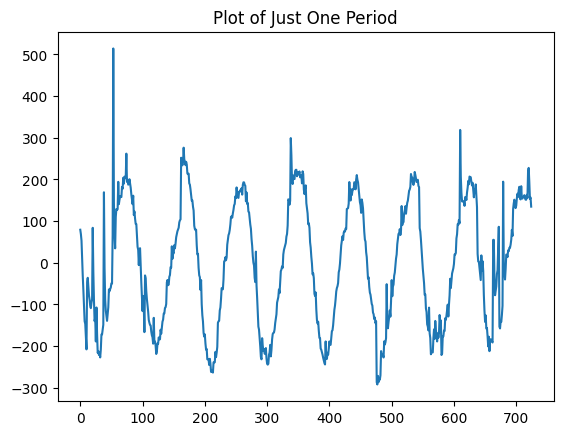

In [ ]:
index = 3 #@param {type:"slider", min:0, max:5050, step:1}
t_0 = 149 #@param {type:"slider", min:0, max:3197, step:1}
period = 725 #@param {type:"slider", min:0, max:3197, step:1}

from matplotlib.patches import Rectangle
light_curve=np.array(non_exo_data.iloc[index])
plt.plot(light_curve)
plt.title('Box Covering One Period')
plt.gca().add_patch(Rectangle((t_0, -510), period, 2050, linewidth=1,edgecolor='r',facecolor='none'))
plt.show()

plt.plot(light_curve[t_0: t_0+period])
plt.title('Plot of Just One Period')
plt.show()

Now, as before, use **folding** to check if the period you identified holds true! What happens when we plot a shifted version of the curve on top of itself?

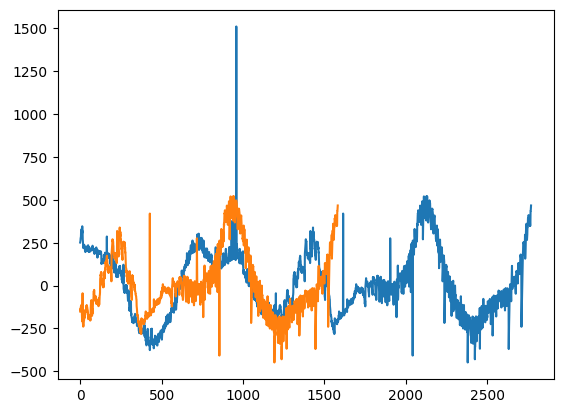

In [ ]:
### YOUR CODE HERE
light_curve=np.array(exo_data.iloc[25])
#Plot the curve starting from Period 1
start_period_1 = 427 ### YOUR CODE HERE - time of first transit
plt.plot(light_curve[start_period_1:]) #plots the first curve

#Plot the curve starting from Period 2
### YOUR CODE HERE
start_period_2 = 427 + 1187
plt.plot(light_curve[start_period_2:])

###Exercise: Identifying Exoplanets

Go back and try changing `index` to try out more examples of exoplanets and non-exoplanets. Try to find the period for at least 3 examples of each!

**Discuss:**
1. Can you reliably identify exoplanets using folding? Is it more accurate than eyeballing?
2. Why might it be challenging to program a computer to identify exoplanets using the folding method?  *Optional challenge exercise:* see if you can translate your process to code!
3. How could machine learning make it easier to identify exoplanets using this dataset?



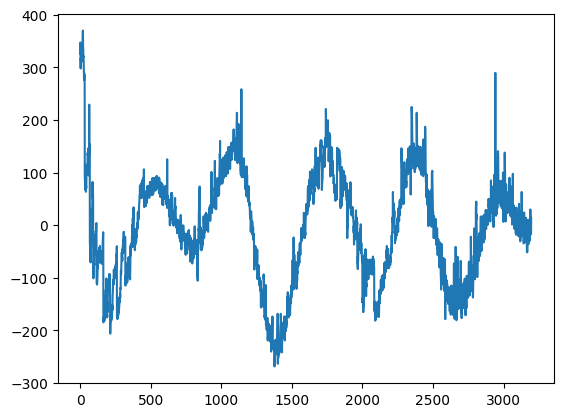

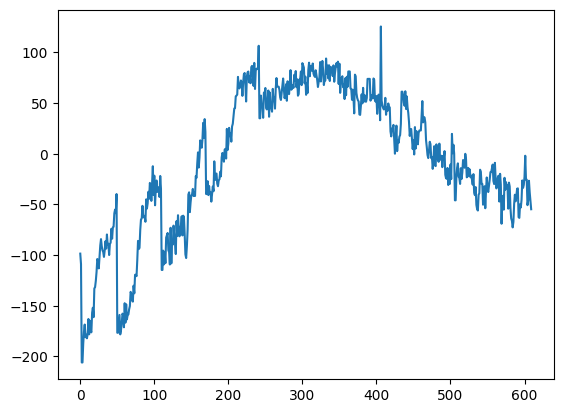

In [ ]:
### YOUR CODE HERE to experiment with anything you'd like!
light_curve=np.array(exo_data.iloc[3])
plot_light_curve(exo_data, 3)
t_0 = 210
start_period_1 = 610
plt.plot(light_curve[t_0:t_0 + start_period_1])
plt.show()


###Conclusion
Today, you've learned how to identify exoplanets using your human intelligence! In the next notebooks, we'll try to automate this process using machine learning.